In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T


In [5]:
DATA_DIR = "/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT"

classes = ["benign", "malignant"]  # ignore "normal" (no masks)

image_paths = []
mask_paths = []

for cls in classes:
    cls_dir = os.path.join(DATA_DIR, cls)
    for fname in os.listdir(cls_dir):
        if "mask" not in fname.lower() and fname.endswith(".png"):
            mask_name = fname[:-4] + "_mask.png"
            img_path = os.path.join(cls_dir, fname)
            mask_path = os.path.join(cls_dir, mask_name)
            if os.path.exists(mask_path):
                image_paths.append(img_path)
                mask_paths.append(mask_path)


In [6]:
class BreastDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform
        self.img_transform = T.Compose([
            T.Resize((256, 256)),
            T.ToTensor()
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.open(self.images[idx]).convert("L")
        mask = Image.open(self.masks[idx]).convert("L")
        img = self.img_transform(img)
        mask = self.img_transform(mask)
        mask = (mask > 0).float()  # binary
        return img, mask


In [8]:
train_imgs, val_imgs, train_masks, val_masks = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)

train_ds = BreastDataset(train_imgs, train_masks)
val_ds = BreastDataset(val_imgs, val_masks)

train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=8)


In [10]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool = nn.MaxPool2d(2, 2)

        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, out_channels, 1)
        )

    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.pool(x1)
        x3 = self.decoder(x2)
        return x3


In [11]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        def CBR(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.ReLU(),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.ReLU()
            )
        self.enc1 = CBR(1, 64)
        self.enc2 = CBR(64, 128)
        self.pool = nn.MaxPool2d(2)
        self.up = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = CBR(128, 64)
        self.out = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        d1 = self.up(e2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        return torch.sigmoid(self.out(d1))


In [2]:
import torch


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(5):
    model.train()
    total_loss = 0
    for x, y in train_dl:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_dl):.4f}")


Epoch 1, Loss: 0.4885
Epoch 2, Loss: 0.3238
Epoch 3, Loss: 0.3200
Epoch 4, Loss: 0.3195
Epoch 5, Loss: 0.3189


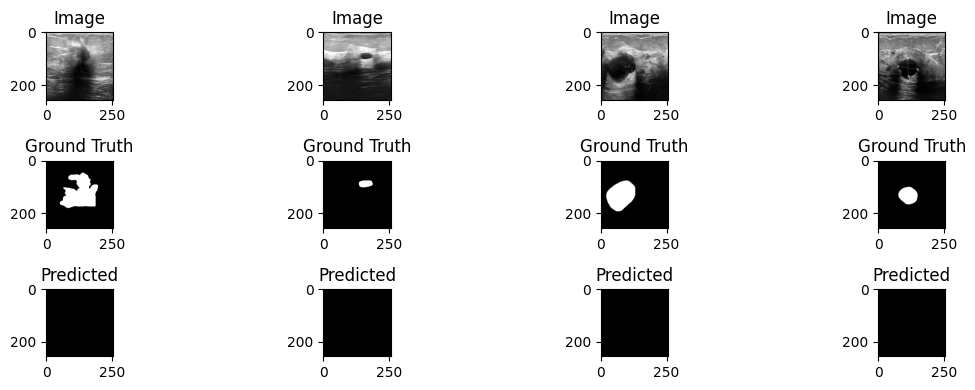

In [13]:
model.eval()
x, y = next(iter(val_dl))
x, y = x.to(device), y.to(device)
with torch.no_grad():
    preds = model(x)

plt.figure(figsize=(12, 4))
for i in range(4):
    plt.subplot(3, 4, i+1)
    plt.imshow(x[i].cpu().squeeze(), cmap='gray')
    plt.title("Image")
    plt.subplot(3, 4, i+5)
    plt.imshow(y[i].cpu().squeeze(), cmap='gray')
    plt.title("Ground Truth")
    plt.subplot(3, 4, i+9)
    plt.imshow(preds[i].cpu().squeeze().numpy() > 0.5, cmap='gray')
    plt.title("Predicted")
plt.tight_layout()
plt.show()
